Notebook to define a function to allocate origins based on zip code level to street level.   
Two aims:   
- get boundary polygon of area under analysis.
- get strretnetwork for boundary and download all streets apart from highways. 
- try allocation strategies. 1) to all streets (apart from highways) 2) download buildings and allocate to streets close to bldgs.

In [2]:
import sys, os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import skmob as skm
import osmnx as ox
import shapely
import pickle
# as jupyter notebook cannot find __file__, import module and submodule path via current_folder
current_folder = globals()['_dh'][0]

PROJECT_SRC_PATH = os.path.realpath(os.path.join(current_folder, '..', '..', 'xml4uf'))
sys.path.append(PROJECT_SRC_PATH)

from ufo_map.Utils.helpers import *

## Mobility data allocation

In [2]:
def read_od(path):
    return pd.read_csv(path,sep=" ",names=['origin','destination','p_combined'],skiprows=6)

In [3]:
def clean_od(df):
    df['origin']=df['origin'].astype(int)
    df['destination']=df['destination'].astype(int)
    return df

In [4]:
def sample_on_p(df):
    # we divide float number to split total number and percentages
    # based on random number between [0,1] we add 1 or 0 to total number for percentages
    df['fix_num'],df['p'] = df['p_combined'].divmod(1)
    df['random'] = np.random.uniform(0,1,len(df))
    df['num_trips'] = df.fix_num
    df.loc[(df.p > df.random),'num_trips'] += 1  
    return df.drop(columns=['fix_num','p','random'])

In [25]:
# define path
path = '/Users/Felix/Documents/Studium/PhD/05_Projects/11_xml4uf_global/data/mobility/BOS/OD0.fma'
# read od_data in cleaned version
df = read_od(path)
df = clean_od(df)
# create sample
df = sample_on_p(df)
df

,origin,destination,p_combined,num_trips
0,100,100,28.872275,29.0
1,100,100100,0.325687,1.0
2,100,100200,0.137299,0.0
3,100,100400,0.208610,0.0
4,100,100500,0.378904,1.0
...,...,...,...,...
190421,985600,91100,0.100048,0.0
190422,985600,92101,0.069182,0.0
190423,985600,981300,0.056410,0.0
190424,985600,981700,0.083018,0.0


## let's check where we have mobility data

In [8]:
gdf = gpd.read_file('/Users/felix/Documents/phd/projects/11_xml4uf_global/data/BOS/mobility/BOS.shp')
gdf.head(3)

,tractid,my_area,geometry
0,630400,9.988907,"POLYGON ((-71.35236 41.93142, -71.35281 41.931..."
1,631100,8.289611,"POLYGON ((-71.35281 41.93117, -71.35236 41.931..."
2,631300,8.960974,"POLYGON ((-71.29017 41.94444, -71.29021 41.944..."


<AxesSubplot:>

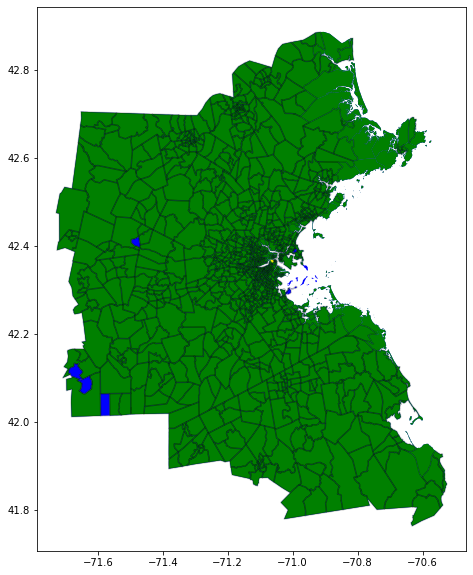

In [43]:
# blue marks where we don't have trips
fig,ax = plt.subplots(figsize=(10,10))
gdf.exterior.plot(ax=ax,color='black',alpha=0.2)
gdf.plot(ax=ax,color='blue')
gdf.loc[gdf.tractid.isin(list(set(df.origin)))].plot(ax=ax,color='green')
gdf.loc[gdf.tractid==20303].plot(ax=ax,color='yellow')

In [4]:
# graph shows that we have trips in basically every area

In [26]:
# lets get the areas with the most trips
df['count'] = df.groupby('origin')['num_trips'].transform('count')
df.sort_values('count',ascending=False)
# 20303 is the one with the most origins (although badly counted)

,origin,destination,p_combined,num_trips,count
23810,20303,417601,0.838698,1.0,852
23624,20303,352102,13.639481,13.0,852
23626,20303,352300,0.607737,1.0,852
23627,20303,352400,0.136235,0.0,852
23628,20303,352500,0.549198,0.0,852
...,...,...,...,...,...
162420,611201,613600,0.416156,0.0,5
162419,611201,613400,0.162844,1.0,5
162418,611201,613100,0.121334,0.0,5
162417,611201,542300,8.165595,8.0,5


# 1) Get boundary of all areas to download the street network for the whole city

In [3]:
bound_geom = gdf.geometry.unary_union
gdf2 = gpd.GeoDataFrame(geometry=[bound_geom], crs=gdf.crs)
gdf2

,geometry
0,"MULTIPOLYGON (((-71.38730 42.01880, -71.38741 ..."


In [73]:
gdf2 = gdf2.to_crs(2806)

In [74]:
gdf2.to_csv('/Users/felix/Documents/phd/projects/11_xml4uf_global/data/bos/streets/bos_boundary.csv',index=False)

<AxesSubplot:>

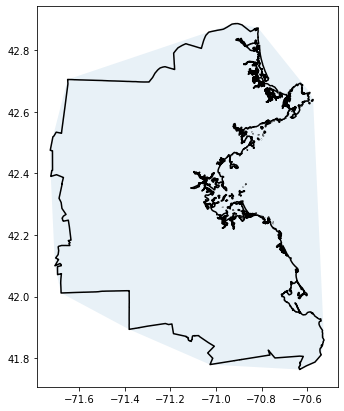

In [4]:
## from the plot we see that we can take the convex hull to download the street network data
# we then need to assign points based on the individual polygons of each district

fig,ax=plt.subplots(figsize=(7,7))
gdf2.convex_hull.plot(ax=ax,alpha=0.1)
gdf2.boundary.plot(ax=ax, color='black')

# 1) Download osm street network for one polygon

In [9]:
gdf

,tractid,my_area,geometry
0,630400,9.988907,"POLYGON ((-71.35236 41.93142, -71.35281 41.931..."
1,631100,8.289611,"POLYGON ((-71.35281 41.93117, -71.35236 41.931..."
2,631300,8.960974,"POLYGON ((-71.29017 41.94444, -71.29021 41.944..."
3,631200,17.019618,"POLYGON ((-71.30786 41.96025, -71.30804 41.959..."
4,631400,0.790492,"POLYGON ((-71.29125 41.94414, -71.29094 41.944..."
...,...,...,...
969,260700,2.537014,"POLYGON ((-71.11598 42.78340, -71.11584 42.783..."
970,260900,2.993848,"POLYGON ((-71.12079 42.76844, -71.12069 42.768..."
971,260800,0.941658,"POLYGON ((-71.09719 42.76304, -71.09696 42.764..."
972,261000,1.511648,"POLYGON ((-71.08517 42.76375, -71.08570 42.763..."


In [5]:
# getting osm street data 
g = ox.graph_from_polygon(gdf.loc[gdf.tractid==20303].geometry.iloc[0],simplify=True,network_type='drive')

In [68]:
gdf_streets = ox.utils_graph.graph_to_gdfs(g, 
                                       nodes=False, 
                                       edges=True,
                                       node_geometry=False, 
                                       fill_edge_geometry=True)

# .to_crs(local_crs)[['osmid','highway','length','geometry']]

In [32]:
set(gdf_streets.highway)

{'motorway',
 'motorway_link',
 'primary',
 'residential',
 'secondary',
 'secondary_link',
 'trunk_link',
 'unclassified'}

<AxesSubplot:>

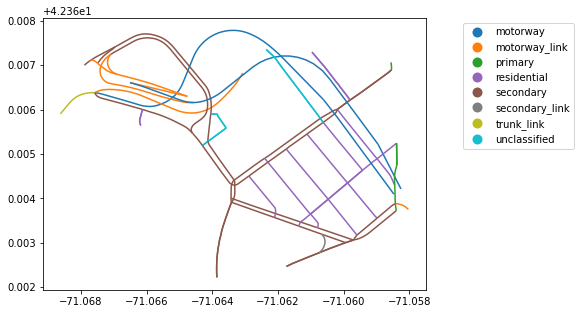

In [86]:
fig,ax = plt.subplots(figsize=(7,5))
gdf_streets.plot(ax=ax, column="highway",legend=True,legend_kwds={'bbox_to_anchor': (1.4, 1)})


In [70]:
dict_excluded_street_types = ['motorway','motorway_link']
gdf_streets.loc[~gdf_streets.highway.isin(['motorway','motorway_link'])]

osmid  oneway lanes              name  \
u          v          key                                              
61339739   3536413237 0    347303564    True     1   Portland Street   
           61339810   0    615374903   False     2       Valenti Way   
61339741   61362200   0     90441529    True     2   Merrimac Street   
           61339739   0    615374902    True   NaN       Valenti Way   
61339810   61343603   0    615374903   False     2       Valenti Way   
...                              ...     ...   ...               ...   
8732786808 1831651816 0    943130159    True     2  Staniford Street   
8733015067 7792998357 0    426456757    True     2  Staniford Street   
           61421606   0    943135381    True     2   Causeway Street   
8733015070 8733015067 0     90296892    True     3      Lomasney Way   
           8732786808 0    943130159    True     2  Staniford Street   

                               highway maxspeed width  reversed   length  \
u          v          key                                                  
61339739   3536413237 0    residential   25 mph  12.2     False  168.020   
           61339810   0    residential   25 mph   NaN     False   57.517   
61339741   61362200   0      secondary   25 mph  27.4     False   66.320   
           61339739   0    residential      NaN   NaN     False   32.269   
61339810   61343603   0    residential   25 mph   NaN     False   63.204   
...                                ...      ...   ...       ...      ...   
8732786808 1831651816 0      secondary   25 mph   NaN     False   10.505   
8733015067 7792998357 0      secondary   25 mph   NaN     False   12.529   
           61421606   0      secondary   25 mph  12.2     False   42.437   
8733015070 8733015067 0      secondary   25 mph  14.0     False    7.947   
           8732786808 0      secondary   25 mph   NaN     False   34.531   

                                                                    geometry  \
u          v          key                                                      
61339739   3536413237 0    LINESTRING (-71.06101 42.36365, -71.06107 42.3...   
           61339810   0    LINESTRING (-71.06101 42.36365, -71.06096 42.3...   
61339741   61362200   0    LINESTRING (-71.06132 42.36347, -71.06186 42.3...   
           61339739   0    LINESTRING (-71.06132 42.36347, -71.06123 42.3...   
61339810   61343603   0    LINESTRING (-71.06047 42.36398, -71.06042 42.3...   
...                                                                      ...   
8732786808 1831651816 0    LINESTRING (-71.06343 42.36401, -71.06343 42.3...   
8733015067 7792998357 0    LINESTRING (-71.06332 42.36430, -71.06332 42.3...   
           61421606   0    LINESTRING (-71.06332 42.36430, -71.06329 42.3...   
8733015070 8733015067 0    LINESTRING (-71.06341 42.36432, -71.06338 42.3...   
           8732786808 0    LINESTRING (-71.06341 42.36432, -71.06342 42.3...   

                           ref access tunnel bridge  
u          v          key                            
61339739   3536413237 0    NaN    NaN    NaN    NaN  
           61339810   0    NaN    NaN    NaN    NaN  
61339741   61362200   0    NaN    NaN    NaN    NaN  
           61339739   0    NaN    NaN    NaN    NaN  
61339810   61343603   0    NaN    NaN    NaN    NaN  
...                        ...    ...    ...    ...  
8732786808 1831651816 0    NaN    NaN    NaN    NaN  
8733015067 7792998357 0    NaN    NaN    NaN    NaN  
           61421606   0    NaN    NaN    NaN    NaN  
8733015070 8733015067 0    NaN    NaN    NaN    NaN  
           8732786808 0    NaN    NaN    NaN    NaN  

[98 rows x 14 columns]

# 3 lets find all street types by using boston's convex hull to download all streets

In [6]:
boston_boundary_geom = gdf2.convex_hull.geometry.iloc[0]

In [12]:
%store boston_boundary_geom

Stored 'boston_boundary_geom' (Polygon)


In [7]:
# getting osm street data 
g_boston = ox.graph_from_polygon(boston_boundary_geom,simplify=True,network_type='drive')

In [9]:
# saving it as pkl file
with open('/Users/felix/Documents/phd/projects/11_xml4uf_global/data/BOS/streets/nxgraph_bos.pickle', 'wb') as handle:
    pickle.dump(g_boston,handle)

In [29]:
gdf_boston_streets = ox.utils_graph.graph_to_gdfs(g_boston, 
                                       nodes=False, 
                                       edges=True,
                                       node_geometry=False, 
                                       fill_edge_geometry=True)

In [35]:
gdf_boston_streets = gdf_boston_streets.reset_index(drop=True)

In [36]:
gdf_boston_streets

,osmid,lanes,ref,name,highway,maxspeed,width,oneway,reversed,length,geometry,bridge,tunnel,junction,access,service,est_width
0,8615227,2,MA 139,North Avenue,secondary,35 mph,15.2,False,False,208.379,"LINESTRING (-70.94649 42.12862, -70.94626 42.1...",NaN,NaN,NaN,NaN,NaN,NaN
1,8615227,2,MA 139,North Avenue,secondary,35 mph,15.2,False,True,238.962,"LINESTRING (-70.94649 42.12862, -70.94687 42.1...",NaN,NaN,NaN,NaN,NaN,NaN
2,8615580,2,NaN,Bates Street,residential,NaN,12.2,False,True,106.556,"LINESTRING (-70.94649 42.12862, -70.94694 42.1...",NaN,NaN,NaN,NaN,NaN,NaN
3,8614650,NaN,NaN,Groveland Drive,residential,NaN,NaN,False,False,158.259,"LINESTRING (-70.96801 42.10181, -70.96816 42.1...",NaN,NaN,NaN,NaN,NaN,NaN
4,8614931,2,NaN,Groveland Street,secondary,NaN,12.2,False,False,180.179,"LINESTRING (-70.96801 42.10181, -70.96788 42.1...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426423,8890358,2,NaN,Gershom Avenue,residential,NaN,12.2,False,False,186.818,"LINESTRING (-71.32746 42.65544, -71.32748 42.6...",NaN,NaN,NaN,NaN,NaN,NaN
426424,8890358,2,NaN,Gershom Avenue,residential,NaN,12.2,False,True,66.729,"LINESTRING (-71.32746 42.65544, -71.32745 42.6...",NaN,NaN,NaN,NaN,NaN,NaN
426425,8891599,2,NaN,Sarah Avenue,residential,NaN,12.2,False,False,72.139,"LINESTRING (-71.32746 42.65544, -71.32712 42.6...",NaN,NaN,NaN,NaN,NaN,NaN
426426,8890358,2,NaN,Gershom Avenue,residential,NaN,12.2,False,True,50.183,"LINESTRING (-71.32765 42.65489, -71.32809 42.6...",NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
gdf_boston_streets[['osmid','lanes','name','highway','oneway','geometry']].to_csv('/Users/Felix/Documents/Studium/PhD/05_Projects/11_xml4uf_global/data/mobility/BOS/streets/bos_streets.csv',index=False)



In [52]:
gdf_boston_streets[['osmid','lanes','name','highway','oneway','geometry']]

,osmid,lanes,name,highway,oneway,geometry
0,8615227,2,North Avenue,secondary,False,"LINESTRING (-70.94649 42.12862, -70.94626 42.1..."
1,8615227,2,North Avenue,secondary,False,"LINESTRING (-70.94649 42.12862, -70.94687 42.1..."
2,8615580,2,Bates Street,residential,False,"LINESTRING (-70.94649 42.12862, -70.94694 42.1..."
3,8614650,NaN,Groveland Drive,residential,False,"LINESTRING (-70.96801 42.10181, -70.96816 42.1..."
4,8614931,2,Groveland Street,secondary,False,"LINESTRING (-70.96801 42.10181, -70.96788 42.1..."
...,...,...,...,...,...,...
426423,8890358,2,Gershom Avenue,residential,False,"LINESTRING (-71.32746 42.65544, -71.32748 42.6..."
426424,8890358,2,Gershom Avenue,residential,False,"LINESTRING (-71.32746 42.65544, -71.32745 42.6..."
426425,8891599,2,Sarah Avenue,residential,False,"LINESTRING (-71.32746 42.65544, -71.32712 42.6..."
426426,8890358,2,Gershom Avenue,residential,False,"LINESTRING (-71.32765 42.65489, -71.32809 42.6..."


In [54]:
set(gdf_boston_streets.iloc[:,3])

TypeError: unhashable type: 'list'

## 4 Downloading osmnx graph with custom filters

In [37]:
# getting osm street data 
g_no_filter = ox.graph_from_polygon(gdf.loc[gdf.tractid==20303].geometry.iloc[0],simplify=True,network_type='drive')
gdf_no_filter = ox.utils_graph.graph_to_gdfs(g_no_filter, 
                                       nodes=False, 
                                       edges=True,
                                       node_geometry=False, 
                                       fill_edge_geometry=True)

In [68]:
#unwanted_types = '["highway"!~"motorway|trunk"]'
unwanted_types = '["highway"~"residential|secondary|tertiary"]'
# getting osm street data with filter
g_filter = ox.graph_from_polygon(gdf.loc[gdf.tractid==20303].geometry.iloc[0],simplify=True,network_type='drive',custom_filter = unwanted_types)


In [69]:
gdf_filter = ox.utils_graph.graph_to_gdfs(g_filter, 
                                       nodes=False, 
                                       edges=True,
                                       node_geometry=False, 
                                       fill_edge_geometry=True)

<AxesSubplot:>

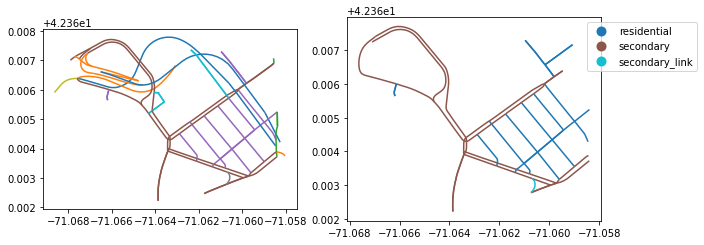

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
gdf_no_filter.plot(ax=ax[0], column="highway")
gdf_filter.plot(ax=ax[1],column='highway',legend=True,legend_kwds={'bbox_to_anchor': (1.4, 1)})

In [28]:
g

In [66]:
set(gdf_boston_streets['highway'])

TypeError: unhashable type: 'list'

In [67]:
gdf_boston_streets

,osmid,lanes,ref,name,highway,maxspeed,width,oneway,reversed,length,geometry,bridge,tunnel,junction,access,service,est_width
0,8615227,2,MA 139,North Avenue,secondary,35 mph,15.2,False,False,208.379,"LINESTRING (-70.94649 42.12862, -70.94626 42.1...",NaN,NaN,NaN,NaN,NaN,NaN
1,8615227,2,MA 139,North Avenue,secondary,35 mph,15.2,False,True,238.962,"LINESTRING (-70.94649 42.12862, -70.94687 42.1...",NaN,NaN,NaN,NaN,NaN,NaN
2,8615580,2,NaN,Bates Street,residential,NaN,12.2,False,True,106.556,"LINESTRING (-70.94649 42.12862, -70.94694 42.1...",NaN,NaN,NaN,NaN,NaN,NaN
3,8614650,NaN,NaN,Groveland Drive,residential,NaN,NaN,False,False,158.259,"LINESTRING (-70.96801 42.10181, -70.96816 42.1...",NaN,NaN,NaN,NaN,NaN,NaN
4,8614931,2,NaN,Groveland Street,secondary,NaN,12.2,False,False,180.179,"LINESTRING (-70.96801 42.10181, -70.96788 42.1...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426423,8890358,2,NaN,Gershom Avenue,residential,NaN,12.2,False,False,186.818,"LINESTRING (-71.32746 42.65544, -71.32748 42.6...",NaN,NaN,NaN,NaN,NaN,NaN
426424,8890358,2,NaN,Gershom Avenue,residential,NaN,12.2,False,True,66.729,"LINESTRING (-71.32746 42.65544, -71.32745 42.6...",NaN,NaN,NaN,NaN,NaN,NaN
426425,8891599,2,NaN,Sarah Avenue,residential,NaN,12.2,False,False,72.139,"LINESTRING (-71.32746 42.65544, -71.32712 42.6...",NaN,NaN,NaN,NaN,NaN,NaN
426426,8890358,2,NaN,Gershom Avenue,residential,NaN,12.2,False,True,50.183,"LINESTRING (-71.32765 42.65489, -71.32809 42.6...",NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
gdf_test = gdf.loc[gdf.tractid==20303].to_crs(2806)
gdf_test.to_csv('/Users/felix/Documents/phd/projects/11_xml4uf_global/data/bos/streets/bos_boundary_test.csv',index=False)

In [12]:
test = 'test'
upper(test)

NameError: name 'upper' is not defined

In [13]:
'test'.upper()

'TEST'

In [34]:
gdf_test = gdf.copy()
gdf_test = gdf_test.to_crs(2806)
gdf_test.crs.to_authority()[1]

'2806'

In [21]:
test = gdf.crs
type(test)

pyproj.crs.crs.CRS

In [29]:
test.name

'WGS 84'

In [36]:
G

NameError: name 'G' is not defined

In [42]:
list_road_types = list(set(gdf_no_filter.highway))

In [43]:
with open("test.txt", "w") as output:
    output.write(str(list_road_types))


